DJI Matrice 600 data processing notebook

In [39]:
import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
import pymap3d as pm
#from math import *
from datetime import datetime
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopy.distance
from scalebar import scale_bar #requires the existance of scalebar.py
import pyproj

import drone

plt.rcParams["figure.figsize"] = (5,5)


In [58]:
#process the files
# USEFUL FILES:
# FLY188: Monday morning grid
# FLY189: Monday morning RFI
# FLY191: Monday afternoon
# FLY196: Tuesday morning RFI
# FLY197: Tuesday morning noise source on
# FLY200: Tuesday afternoon absolute GPS test
# FLY203: Wednesday morning
# FLY204: Wednesday morning
# FLY206_FLY207_FLY208_FLY209_FLY210: Wednesday afternoon absolute
# FLY215: Thursday morning beam map

# Write down the name of our file for future reference
#NAME = 'FLY206_FLY207'
NAME = 'FLY215'

#drone.process_files([NAME])


In [59]:
## Now read in the file we just created
df = pd.read_csv("./csv_out/"+NAME+"_processed.csv", sep=',', header=0)
print(df.columns)

df = df.assign(timestamp = pd.to_datetime(df['timestamp'].values))
df = df.where(df != 0.) 
df.dropna(thresh=2, inplace=True)

print(df.columns)


# set the plot border
drone.set_border(0.09)

Index(['Unnamed: 0', 'Lat', 'Lon', 'hmsl', 'sec_elapsed', 'datetimestamp',
       'tick', 'vel', 'yaw', 'timestamp'],
      dtype='object')
Index(['Unnamed: 0', 'Lat', 'Lon', 'hmsl', 'sec_elapsed', 'datetimestamp',
       'tick', 'vel', 'yaw', 'timestamp'],
      dtype='object')


0

In [60]:
# Fill in some extra columns
df = drone.fill_moving(df)#, method='vel', vel_thresh=0.1)
print(df.columns)

df = drone.fill_avMov(df)
print(df.columns)

Index(['Unnamed: 0', 'Lat', 'Lon', 'hmsl', 'sec_elapsed', 'datetimestamp',
       'tick', 'vel', 'yaw', 'timestamp', 'std_lat', 'std_lon', 'std_hmsl',
       'isMoving'],
      dtype='object')
Index(['Unnamed: 0', 'Lat', 'Lon', 'hmsl', 'sec_elapsed', 'datetimestamp',
       'tick', 'vel', 'yaw', 'timestamp', 'std_lat', 'std_lon', 'std_hmsl',
       'isMoving', 'avMovLat', 'avMovLon', 'avMovHmsl'],
      dtype='object')


<IPython.core.display.Javascript object>


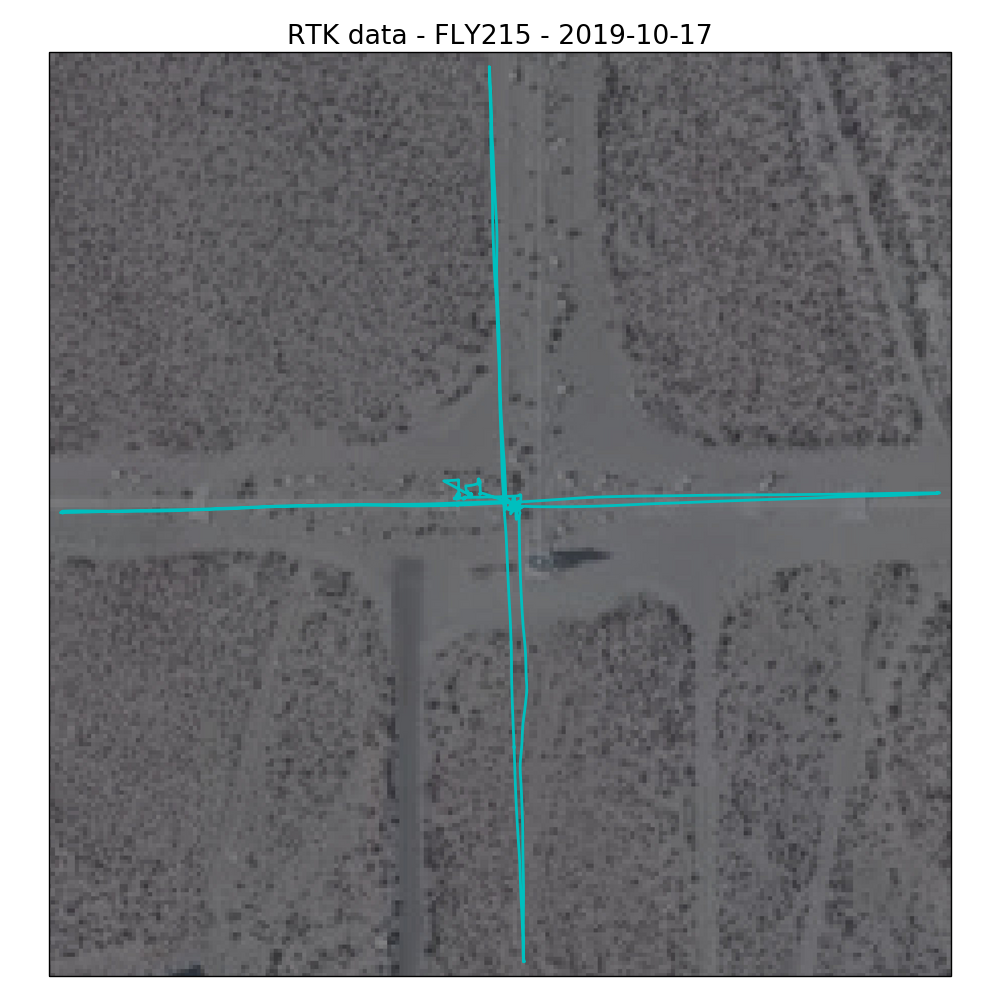

In [61]:
# Plot the flight path
%matplotlib notebook 
drone.plot_satellite(df, NAME)


In [62]:
# pick the center and generate local coordinates
df = drone.make_ENU(df, lat_origin=37.233385, lon_origin=-118.283470, height_origin=42.5)
df = drone.make_az_el(df, lat_origin=37.233385, lon_origin=-118.283470, height_origin=42.5)


37.233385
-118.28347
37.233385
-118.28347


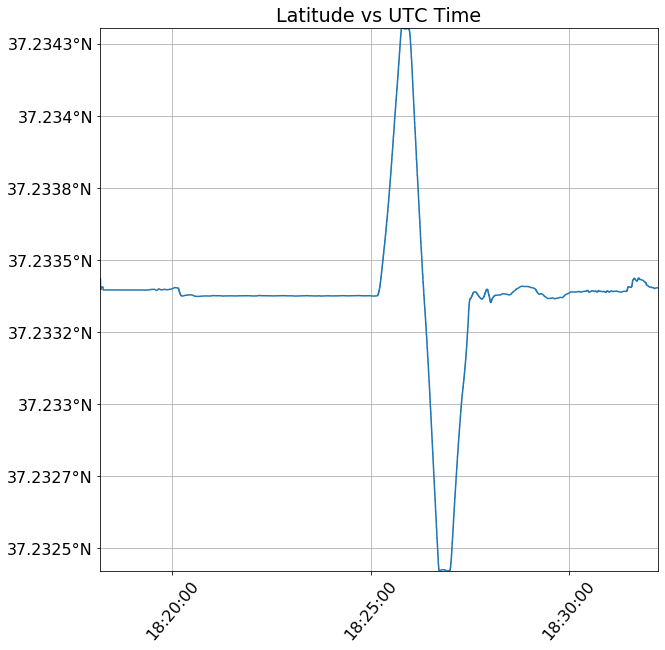

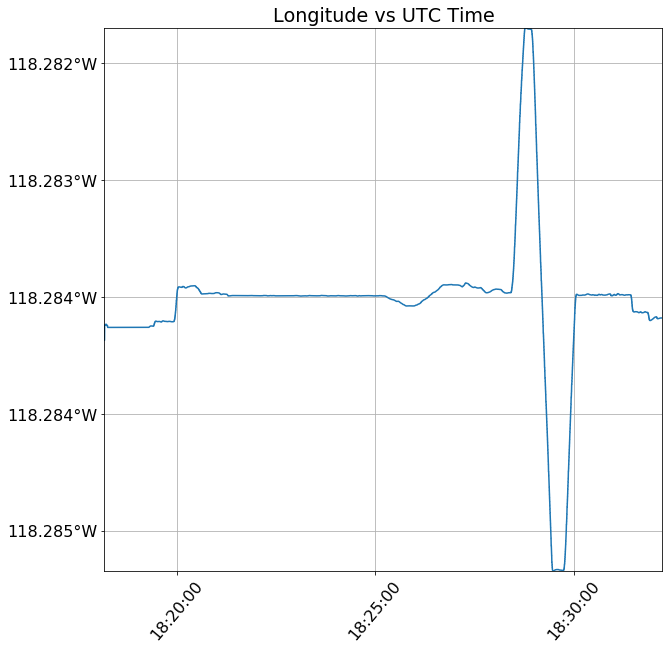

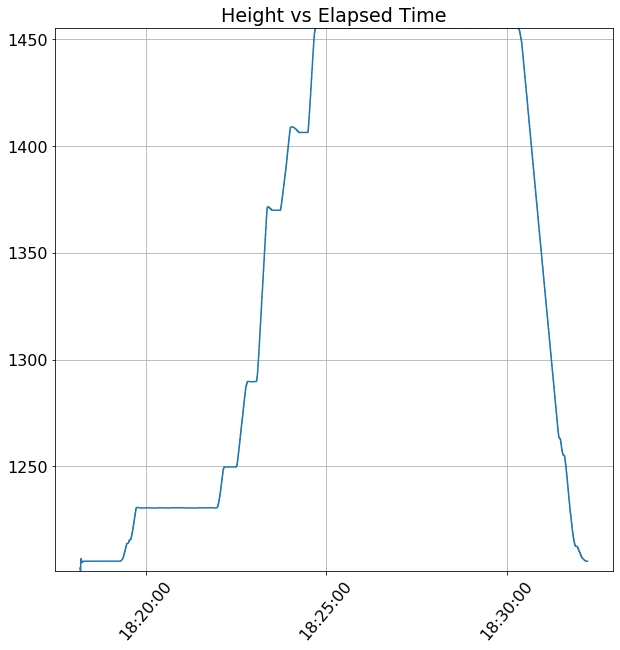

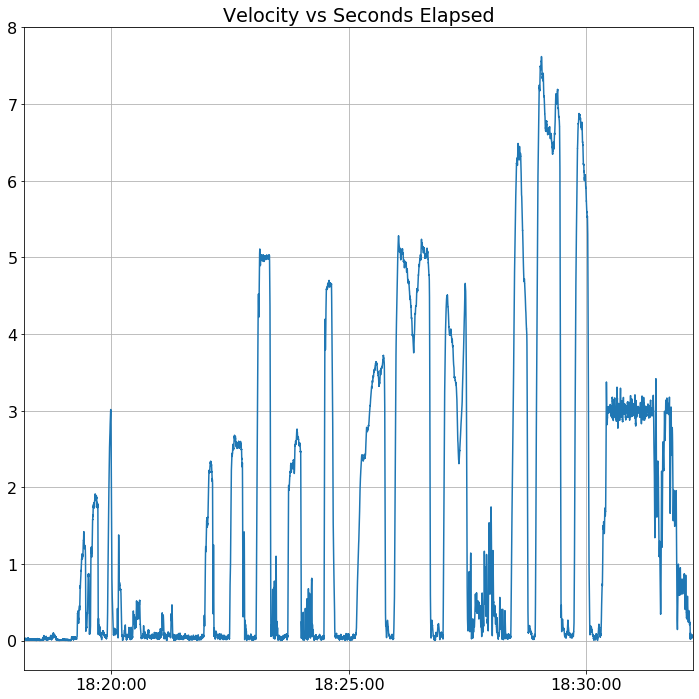

<IPython.core.display.Javascript object>

KeyError: 'yaw_rtk'

In [63]:
# Plot latitude, longitude, and height
%matplotlib inline
drone.plot_latitude(df, NAME)
drone.plot_longitude(df, NAME)
drone.plot_height(df, NAME)
drone.plot_vel(df, NAME)

%matplotlib notebook
drone.plot_yaw(df, NAME)
drone.plot_height(df, NAME)


hello stationary stats
Diagonal distance: 0.06906515153577567 meters
Max distance from center: 0.03275322632810074
Mean distance from center: 0.006677957552441233
StdDev from center: 0.0057868981140735305
hello stationary stats
Diagonal distance: 0.021210264024632785 meters
Max distance from center: 0.010545756283345689
Mean distance from center: 0.0030136202529355356
StdDev from center: 0.0016692195678386058
hello stationary stats
Diagonal distance: 0.02949962499917739 meters
Max distance from center: 0.016576728665208932
Mean distance from center: 0.005127194476439756
StdDev from center: 0.0035041093778157713
hello stationary stats
Diagonal distance: 0.03786478840164043 meters
Max distance from center: 0.01703543382132471
Mean distance from center: 0.006761811962720269
StdDev from center: 0.003951565375261036
hello stationary stats
Diagonal distance: 0.048220874381353 meters
Max distance from center: 0.021916040432875587
Mean distance from center: 0.007415394567215909
StdDev from cen

<IPython.core.display.Javascript object>


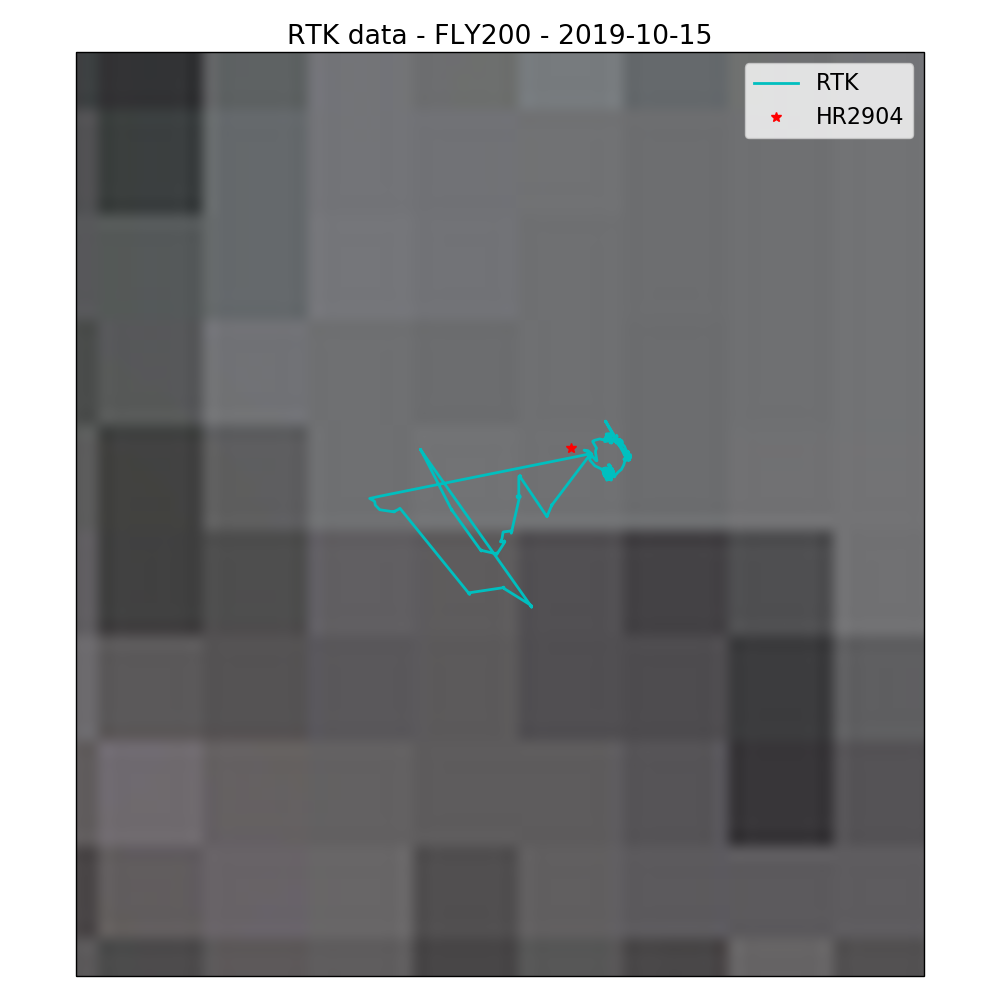

<IPython.core.display.Javascript object>


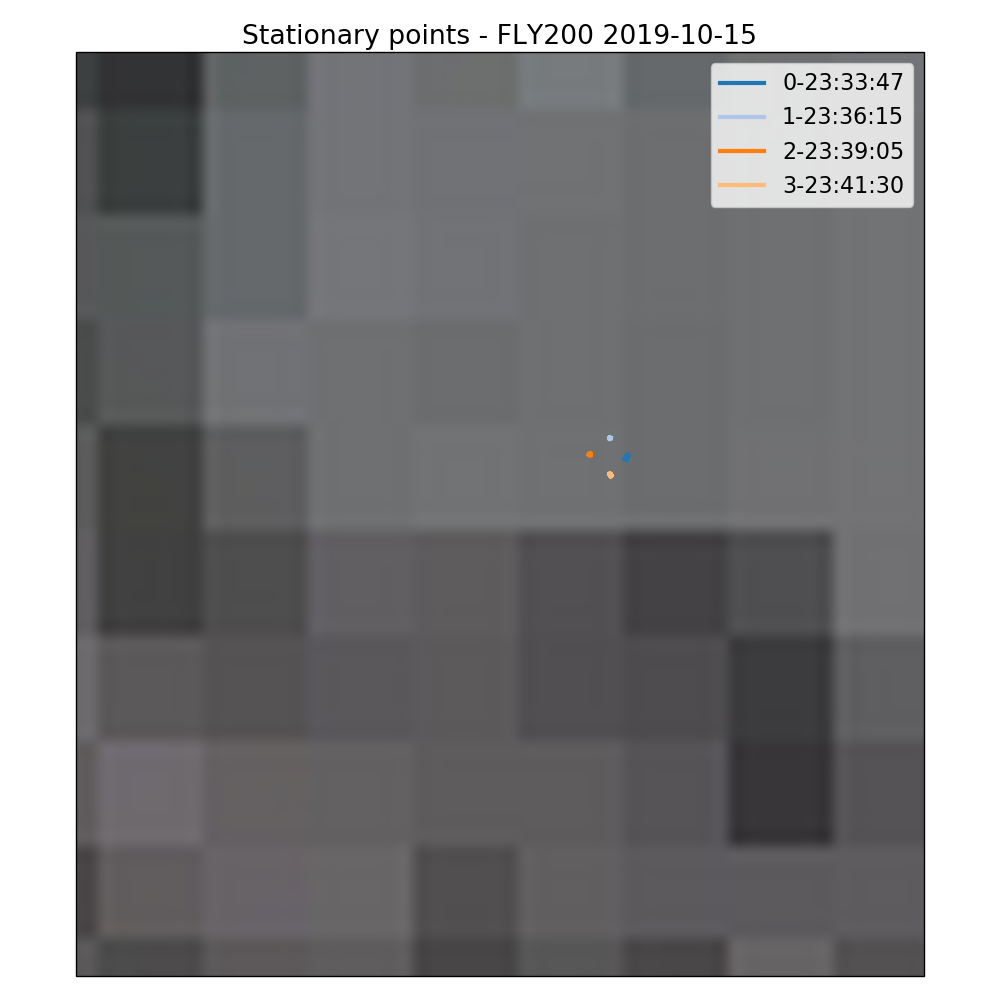

saved plot


In [57]:
# check alignment with NGS marker
#################################
# NOTE: I am assuming the drone reports in WGS84/NAD83 compatible coordinates.
# This is a nontrivial assumption, and worth asking DJI about

marker_lat = 37. + 13./60. + 57.20012/3600.
marker_lon = -1.*(118.+ 17./60. + 37.61026/3600.)
marker = (marker_lat, marker_lon)

### DO NOT DELETE
### Processing absolute GPS tests
if(NAME == 'FLY200'):
    point0 = drone.chop_time(df, np.datetime64("2019-10-15T23:33:47"), np.datetime64("2019-10-15T23:35:15")) #yaw=0
    point1 = drone.chop_time(df, np.datetime64("2019-10-15T23:36:15"), np.datetime64("2019-10-15T23:37:25")) #yaw=265
    point2 = drone.chop_time(df, np.datetime64("2019-10-15T23:39:05"), np.datetime64("2019-10-15T23:40:00")) #yaw=180
    point3 = drone.chop_time(df, np.datetime64("2019-10-15T23:41:30"), np.datetime64("2019-10-15T23:42:05")) #yaw=75ish
    point4 = drone.chop_time(df, np.datetime64("2019-10-15T23:42:40"), np.datetime64("2019-10-15T23:43:45")) #yaw=359
elif(NAME == 'FLY206_FLY207'):
    point0 = drone.chop_time(df, np.datetime64("2019-10-16T22:19:20"), np.datetime64("2019-10-16T22:22:00")) #north
    point1 = drone.chop_time(df, np.datetime64("2019-10-16T22:24:25"), np.datetime64("2019-10-16T22:27:00")) #west
    point2 = drone.chop_time(df, np.datetime64("2019-10-16T22:29:00"), np.datetime64("2019-10-16T22:32:00")) #south
    point3 = drone.chop_time(df, np.datetime64("2019-10-16T22:34:30"), np.datetime64("2019-10-16T22:36:55")) #east
    point4 = drone.chop_time(df, np.datetime64("2019-10-16T22:39:45"), np.datetime64("2019-10-16T22:42:20")) #north again

points = [point0, point1, point2, point3, point4]
point_coords = []
point_dists = []

df = df.assign(point = np.full_like(df['tick'].values, -1))
this_point = 0
for point in points:
    left_index = np.where(df['timestamp'].values == min(point['timestamp'].values))[0][0]
    right_index= np.where(df['timestamp'].values == max(point['timestamp'].values))[0][0]
    point_arr = df['point'].values
    for i in range(left_index, right_index):
        point_arr[i] = this_point
    df = df.assign(point = point_arr)
    this_point += 1
    point_coords.append((np.mean(point['Lat'].values), np.mean(point['Lon'].values)))
    point_dists.append(geopy.distance.distance(marker, point_coords[-1]).m)

for i in range(len(points)):
    drone.point_stats(df, i)
    
for i in range(len(points)-1):
    drone.dist_between_points(df, i, i+1)
  
drone.dist_between_points(df, 0, 2)
    


print(marker)
for i in range(len(points)):
    print("Point "+str(i)+" is "+str(point_dists[i])+"m away from the marker")
    
print(point_coords)
center_coord = (np.mean([x[0] for x in point_coords]), np.mean([x[1] for x in point_coords]))
print(center_coord)
print("The mean position is "+str(geopy.distance.distance(marker, center_coord).m)+"m away from the marker")
print(str(geopy.distance.distance(marker, (center_coord[0], marker[1])).m)+" meters North")
print(str(geopy.distance.distance(marker, (marker[0], center_coord[1])).m)+" meters East")
        
#marker_old = (37. + 13./60. + 57.19937/3600., -1.*(118.+ 17./60. + 37.60922/3600.))

print("Turned RTK and drone off, then back on, at same position")
#print("Offset: "+str(drone.dist_between_times(df, np.datetime64("2019-10-16T23:11:00"), np.datetime64("2019-10-16T23:16:00"))))

# Plot the flight path
%matplotlib notebook 
drone.plot_satellite(df, NAME)
plt.plot(marker[1], marker[0] ,'r*', markersize=7, transform=ccrs.Geodetic(), label="HR2904")
#plt.plot(marker_old[1], marker_old[0] ,'g*', markersize=7, transform=ccrs.Geodetic(), label="2007 Coords")
plt.legend()
#fig.save_fig('./plots/'+NAME+'_marker.png')
plt.show()

# note: I have tried a bunch of different coordinate transformations.
# None of them yield errors small enough to account for this

drone.plot_points(df, NAME)

<IPython.core.display.Javascript object>


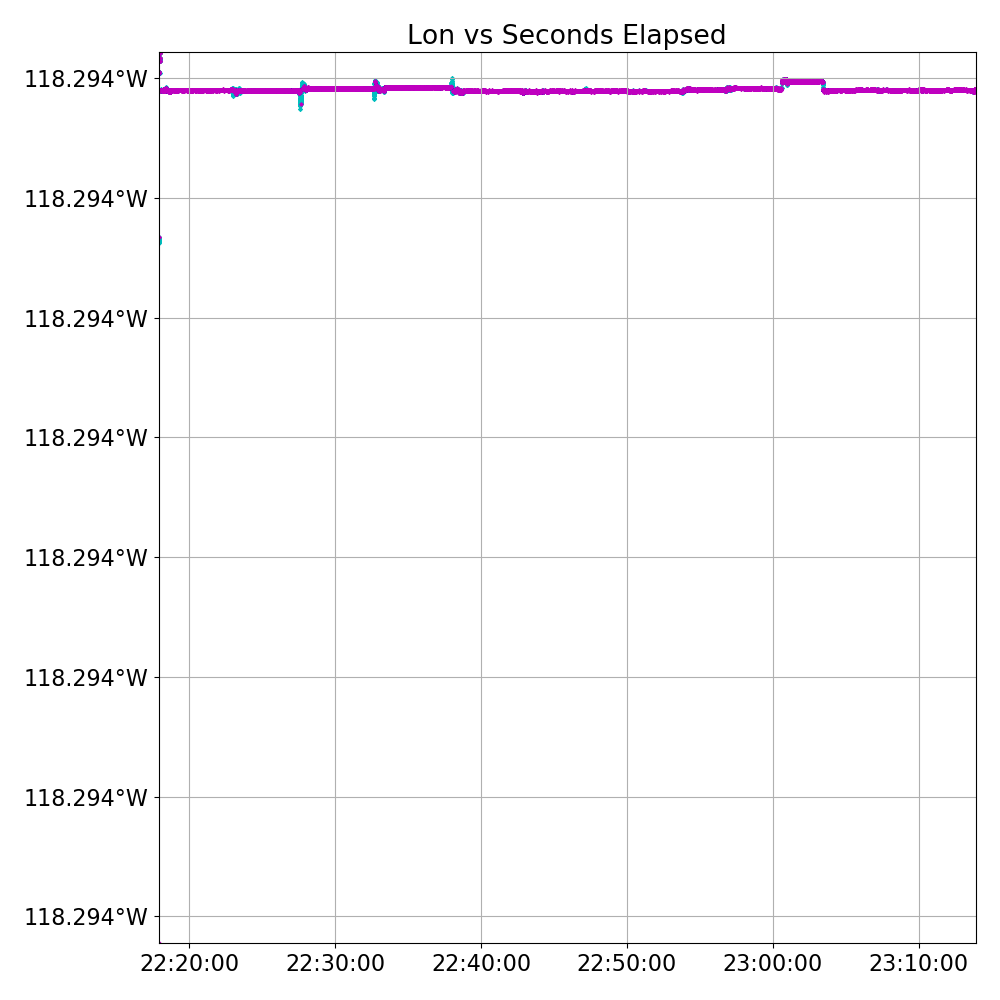

<IPython.core.display.Javascript object>


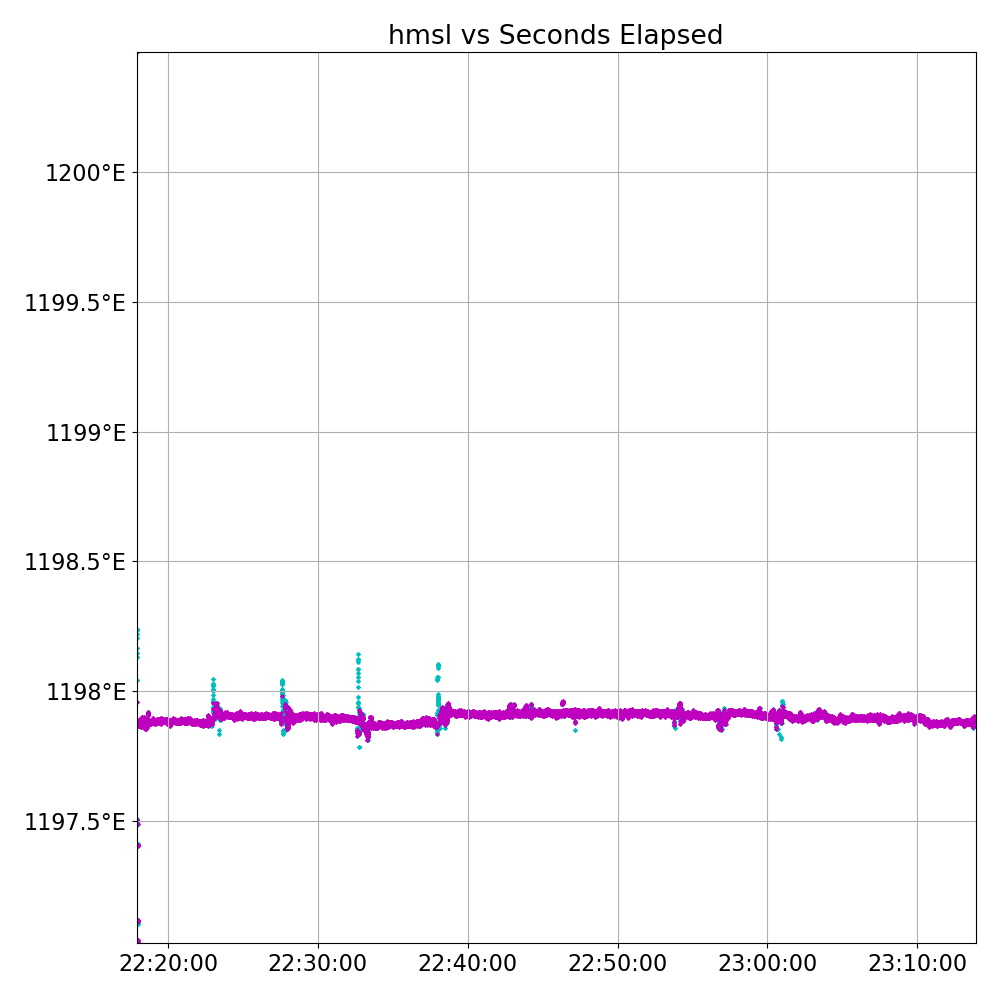

In [28]:
# Make a dataframe containing only our beammapping data
df_cut = df# drone.chop_time(df, np.datetime64("2019-10-15T17:42:00"), np.datetime64("2019-10-15T17:53:30"))

# Make the plot we'll use to tag points
%matplotlib notebook 
# this adds a time readout to the bottom right corner
drone.plot_moving(df_cut, NAME)
drone.plot_moving(df_cut, NAME, view='hmsl')

In [9]:
#tag points with the fancy automated point tagger!!
df_tagged = drone.find_points(df_cut, np.datetime64("2019-10-15T17:42:00"), np.datetime64("2019-10-15T17:53:30"))

# now, tag the points! (this is the annoying part)
#if("point" in df.columns): df = df.drop(columns=['point'])
#df = drone.mark_point(df, np.datetime64("2019-07-11T19:54:59"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T19:55:53"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T19:56:33"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T19:57:30"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T19:58:11"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T19:58:46"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T19:59:30"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:00:06"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:00:36"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:01:08"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:01:42"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:02:22"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:02:58"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:03:27"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:04:16"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:04:59"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:05:33"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:05:58"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:06:30"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:07:01"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:07:29"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:07:59"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:08:22"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:08:48"))
#df = drone.mark_point(df, np.datetime64("2019-07-11T20:09:21"))
print(df_tagged['point'].values)

2019-10-15T17:42:40.196000000
2019-10-15T17:44:10.680000
2019-10-15T17:42:40.196000000
0
8651
2019-10-15T17:44:10.721000000
2019-10-15T17:44:11.392000
2019-10-15T17:44:10.721000000
8655
8720
2019-10-15T17:44:41.487000000
2019-10-15T17:44:42.258000
2019-10-15T17:44:41.487000000
11645
11720
2019-10-15T17:44:44.390000000
2019-10-15T17:44:50.186000
2019-10-15T17:44:44.390000000
11928
12492
2019-10-15T17:44:56.847000000
2019-10-15T17:44:59.710000
2019-10-15T17:44:56.847000000
13140
13418
2019-10-15T17:44:59.782000000
2019-10-15T17:45:01.635000
2019-10-15T17:44:59.782000000
13425
13605
2019-10-15T17:45:02.885000000
2019-10-15T17:45:05.090000
2019-10-15T17:45:02.885000000
13726
13940
2019-10-15T17:45:08.298000000
2019-10-15T17:45:18.581000
2019-10-15T17:45:08.298000000
14251
15252
2019-10-15T17:45:20.915000000
2019-10-15T17:45:23.387000
2019-10-15T17:45:20.915000000
15479
15719
2019-10-15T17:45:29.067000000
2019-10-15T17:45:32.046000
2019-10-15T17:45:29.067000000
16271
16560
2019-10-15T17:45:

<IPython.core.display.Javascript object>


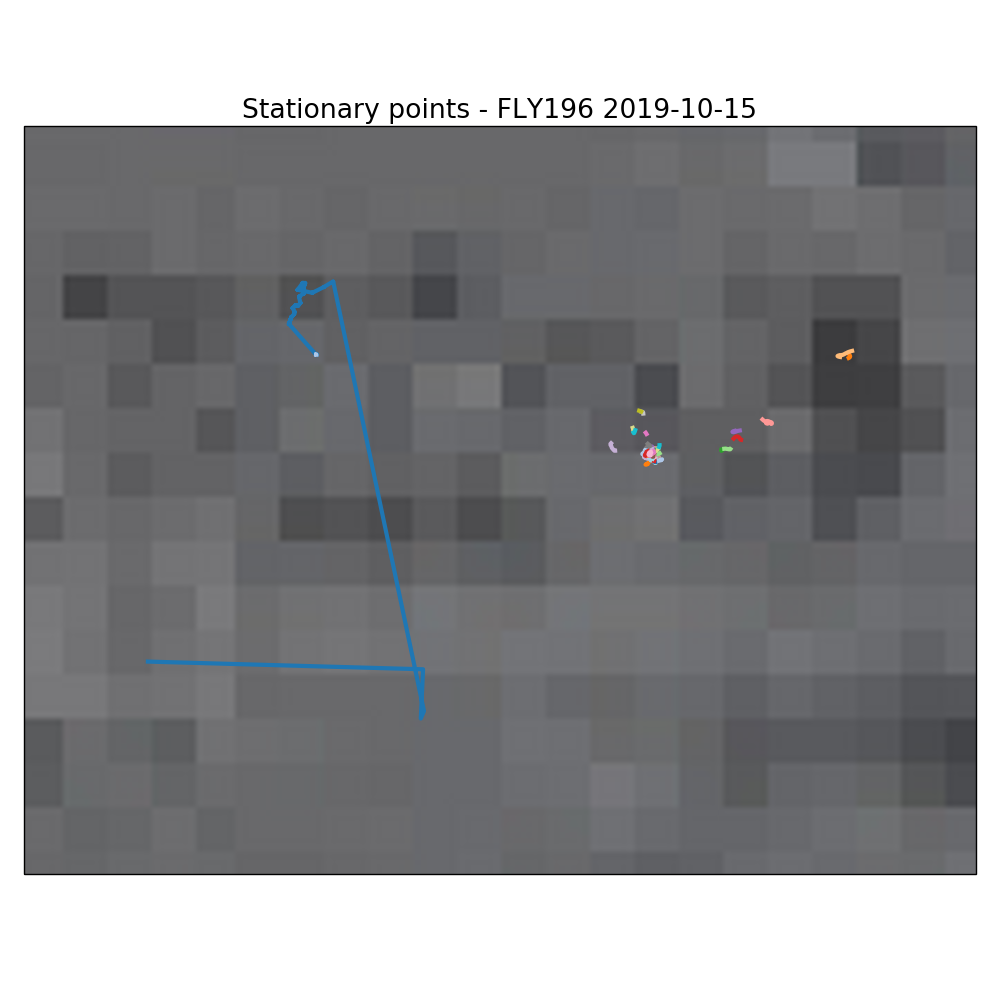

saved plot


In [11]:
# Plot the points
drone.plot_points(df_tagged, NAME, legend=False)

In [11]:
# save the points as an NPZ (to give to Will)
drone.output_points(df, NAME)

KeyError: 'point'

In [ ]:
# report the statistics of a couple of points
drone.point_stats(df, 2)